## Training with XGBoost
Why choose XGBoost instead of a random forest: https://medium.com/geekculture/xgboost-versus-random-forest-898e42870f30 \
A great reference for tuning xgboost:
https://towardsdatascience.com/from-zero-to-hero-in-xgboost-tuning-e48b59bfaf58

This notebook contains the training of an XGBoost regressor model on insider data, which attempts to predict the maximum 90-day percentage gain of a ticker whose insider(s) made a trade. We use a custom objective function that penalizes overestimates more harshly than underestimates.

In [1]:
%load_ext autoreload
%autoreload 1
%aimport my_functions

import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import seaborn as sn
import os

from sklearn.metrics import mean_squared_error, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from operator import itemgetter

from my_functions import *

pd.options.mode.chained_assignment = None
plt.style.use('fivethirtyeight')

In [2]:
'''
Some XGBoost-specific parameters we will use throughout this notebook.
'''
EARLY_STOPPING = 25
N_ESTIMATORS = 500

In [3]:
'''
Read in the trade data and prepare it for modeling.
'''

DAYS_TO_LOOK_BACK = 5  # used for calculating volume volatility and recent-trade counts
BIN_STARTS = [0, 1, 10]  # these are the boundaries between output-oversampling intervals

train_cv_test_set = my_model_prep.prepareForModel(pd.read_csv('../data/training_cv_test.csv'))

testStartDate = max(train_cv_test_set.FilingDate) - dt.timedelta(days=14)
train_cv_set = train_cv_test_set.loc[train_cv_test_set.FilingDate < testStartDate]
test_set = train_cv_test_set.loc[train_cv_test_set.FilingDate >= testStartDate]
test_set.to_csv('../data/test.csv')

train_set, cv_set = train_test_split(train_cv_set, test_size=0.05, shuffle=True, random_state=42)

trainStartDate = min(train_set.FilingDate) + dt.timedelta(days=DAYS_TO_LOOK_BACK)
train_XY, train_X, train_Y = my_model_prep.returnXandY(
    train_set.loc[train_set.FilingDate > trainStartDate], binStarts=BIN_STARTS
)

cv_XY, cv_X, cv_Y = my_model_prep.returnXandY(cv_set, binStarts=BIN_STARTS)

In [4]:
print(f'Train shape: {train_X.shape}')
print(f'CV shape: {cv_X.shape}')

Train shape: (20994, 11)
CV shape: (1080, 11)


In [5]:
# We'll need this later.
def plotLearningCurves(results, losses):
    '''
    Plot the XGBoost training and cross-validation learning curves for each loss.
    
    IN:
        results (obtained from an XGBoost fit)
        losses (List[str]): contains name of each validation metric
    '''
    fig, axs = plt.subplots(1, len(losses), figsize=(6.4*len(losses), 4.8))
    if type(axs) != np.ndarray: axs = [axs]
        
    for i, name in enumerate(losses):
        axs[i].plot(results['validation_0'][name], label='train')
        axs[i].plot(results['validation_1'][name], label='cv')
        axs[i].set_xlabel('Epoch')
        axs[i].set_ylabel('Loss')
        axs[i].set_title('Learning Curve: ' + name)
        axs[i].legend()

    plt.show()

#### Let's create an XGBRegressor object and tune the hyperparameters with RandomizedSearchCV.

In [6]:
# Create parameter grid
parameters = {
    'learning_rate': [5e-2, 1e-2, 5e-3],     # smaller = more conservative
    'min_split_loss' : [1e-2, 0.1, 1.],  # larger = more conservative
    'max_depth': [4, 5, 6, 7],           
    'max_delta_step': [0., 1., 10., 100.],   # can help with imbalanced classes
    'colsample_bytree': [0.6, 0.8, 1.],
    'subsample': [0.5, 0.6, 0.7],           # lower values should help with overfitting
    'reg_lambda': [10., 50., 100., 500.],          # regularization controls overfitting
    'min_child_weight': [1., 3., 5.],       # larger = more conservative
}

In [7]:
xgb_model_best = my_models.XGBReg(
    train_X, train_Y, cv_X, cv_Y, 
    objective=None,  # defaults to rmse
    metric=None,  # defaults to rmse
    parameters=parameters, 
    earlyStopping=EARLY_STOPPING, 
    n_estimators=N_ESTIMATORS
)

Best learning_rate, min_split_loss, max_depth, max_delta_step, colsample_bytree, subsample,
reg_lambda, min_child_weight:
(0.05, 1.0, 6, 0.0, 0.8, 0.7, 10.0, 1.0)


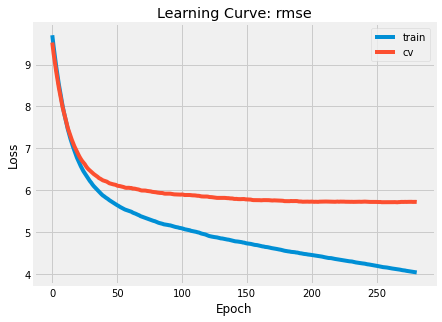

In [8]:
results = xgb_model_best.evals_result()
plotLearningCurves(results, ['rmse'])

Our model definitely learns, but it might be overfitting the training data.

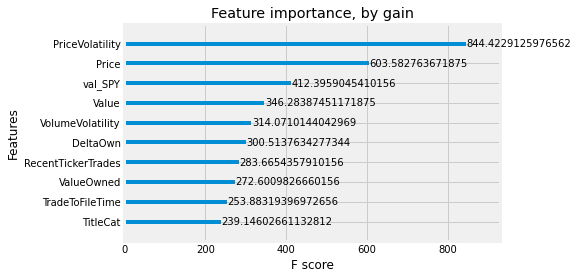

In [9]:
xgb.plot_importance(xgb_model_best, importance_type='gain')
plt.title('Feature importance, by gain')
plt.show()

The feature importance map is interesting and a cause for some consideration, particularly because ticker price is second-most important indicator of future price.

I think that this can be seen as either a bit concerning, or a bit tautological. On the one hand, we'd naturally not expect price to give any sort of indication of what the future price will be -- it's just an arbitrary value! But on the other hand, even though share structure is what's actually important in determining how easily the price can jump, I suspect that it usually is such that higher-priced tickers don't tend to run as easily as lower-priced tickers. Thus, it's just inherently more likely that a 1-dollar ticker increases by 10 cents than a 100-dollar ticker increases by 10 dollars.

Price volatility is by far the most important feature. This is also a bit tautological.

The percentage change in an insider's position, 'DeltaOwn', has less importance than the total value of the trade. This may be because those who monitor insider trades for bullish signals probably pay more attention to the total trade value than the percentage change in position.

Also, the importance of an insider's title is not very important!

### Let's visualize our predictions vs. the actual price percentage increase.

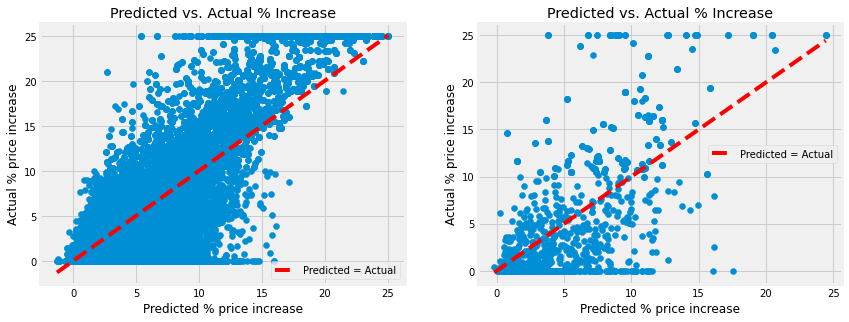

In [10]:
train_Y_preds = xgb_model_best.predict(train_X)
cv_Y_preds = xgb_model_best.predict(cv_X)

my_plots.plotPredictedVsActual(train_Y_preds, train_Y, cv_Y_preds, cv_Y)

Training is on the left, CV is on the right.

### Everything below the dotted line is an overestimate.

That's not good: we don't want to be confident that a stock will gain a lot, only for it to underperform. On the contrary, if a stock outperforms our expectations and we've bought into it at all, then that's great!

As a side note, in training, we are overpredicating low-performers and underpredicting high-performers, which seems to indicate an imbalance in output representation. However, I have already attempted to address this with overrepresentation. Perhaps this is only occurring due to early stopping.

### Let's define a custom objective function...

...that penalizes overestimated non-gainers (by 4x) as well as underestimated gainers >10% (by 2x).

In [11]:
def asymm_rmse(y_true, y_pred):
    '''
    A custom rmse loss function that penalizes overestimated non-gains by 4x and underestimated gains by 2x.
    '''
    # I'm honestly confused about when a DMatrix is passed to this function vs. an ndarray,
    # so this is a cheeky patch
    if type(y_true) != np.ndarray: y_true = y_true.get_label()

    isOverestimatedLoss = ((y_true < y_pred) & (y_true < 0.1)).astype(float)
    isUnderestimatedGain = ((y_true > y_pred) & (y_true > 10)).astype(float)

    diff = (4*isOverestimatedLoss + 2*isUnderestimatedGain + 1)*np.square(y_pred-y_true)

    loss = np.sqrt(np.mean(diff, axis=-1))

    return loss


def asymm_grads(y_true, y_pred):
    '''
    Gradient and Hessian for asymm_rmse.
    '''
    isOverestimatedLoss = ((y_true < y_pred) & (y_true < 0.1)).astype(float)
    isUnderestimatedGain = ((y_true > y_pred) & (y_true > 10)).astype(float)  

    grad = 2*(4*isOverestimatedLoss + 2*isUnderestimatedGain + 1)*(y_pred-y_true)
    hess = 2*(4*isOverestimatedLoss + 2*isUnderestimatedGain + 1)

    return grad, hess

In [12]:
xgb_model_custom_best = my_models.XGBReg(
    train_X, train_Y, cv_X, cv_Y, 
    objective=asymm_grads,  
    metric=asymm_rmse,  
    parameters=parameters, 
    earlyStopping=EARLY_STOPPING, 
    n_estimators=N_ESTIMATORS
)

Best learning_rate, min_split_loss, max_depth, max_delta_step, colsample_bytree, subsample,
reg_lambda, min_child_weight:
(0.05, 1.0, 6, 0.0, 0.8, 0.7, 10.0, 1.0)


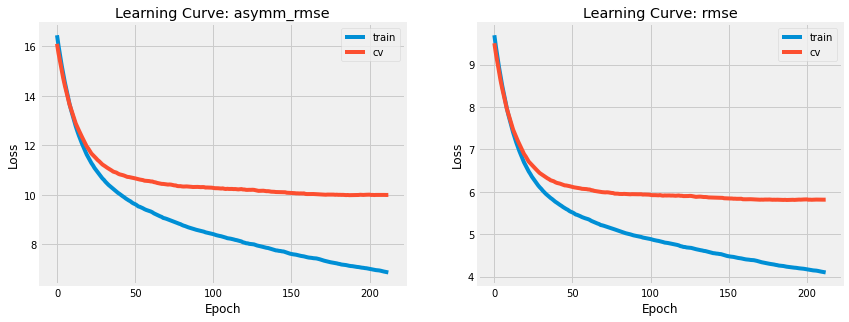

In [13]:
results_custom = xgb_model_custom_best.evals_result()

plotLearningCurves(results_custom, ['asymm_rmse', 'rmse'])

This might be a sign that we have overfit the training set. Let's compare the predicted and actual increases.

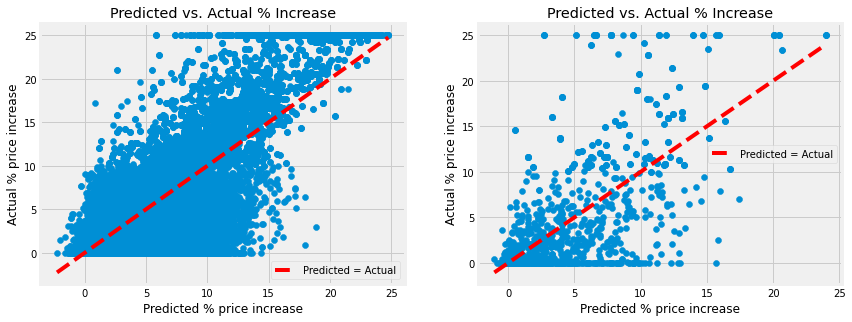

In [14]:
train_Y_preds_custom = xgb_model_custom_best.predict(train_X)
cv_Y_preds_custom = xgb_model_custom_best.predict(cv_X)
my_plots.plotPredictedVsActual(train_Y_preds_custom, train_Y, cv_Y_preds_custom, cv_Y)

Training is on the left, CV is on the right.

TRAINING: the regressor has learned how to avoid egregious overestimates of losses a bit better. Now most of the loss overestimates are no more than 5%.

CV: This leaves a lot to be desired. It doesn't look like there was too much of a change from the normal RMSE loss, so perhaps we need to bump up our bias weights in the custom loss.

### Let's visualize our categorizations with a confusion matrix.

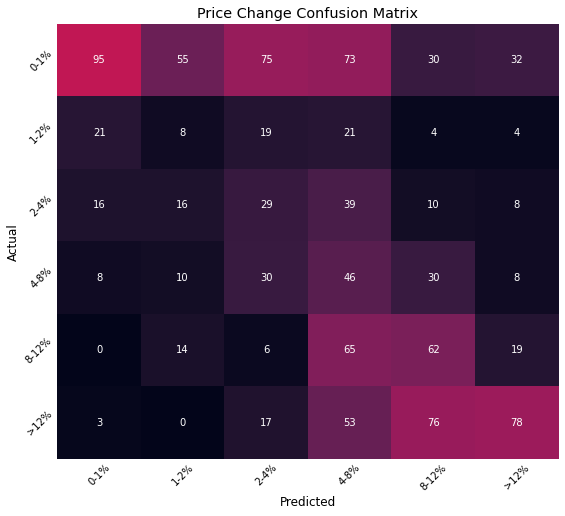

In [15]:
my_plots.confusionMatrix(cv_Y_preds_custom, cv_Y.to_numpy(), intervalBounds=[0,1,2,4,8,12], maxNumInCat=200)

A "confused" matrix indeed. We successfully indicated a lot of large gains, but we also incorrectly predicted that many trades would yield large gain when the actually gave a non-gain.

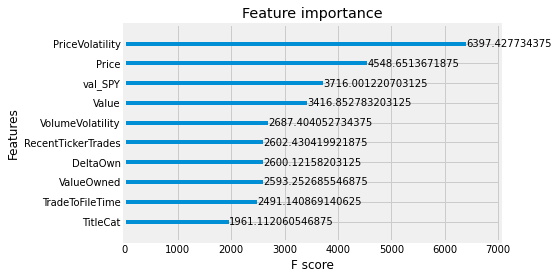

In [16]:
xgb.plot_importance(xgb_model_custom_best, importance_type='gain')
plt.show()

The feature importances remain essentially the same as for the RMSE loss. We've certainly learned that insider title, on the whole, does not give that much insight into the direction that a ticker's price will trend!

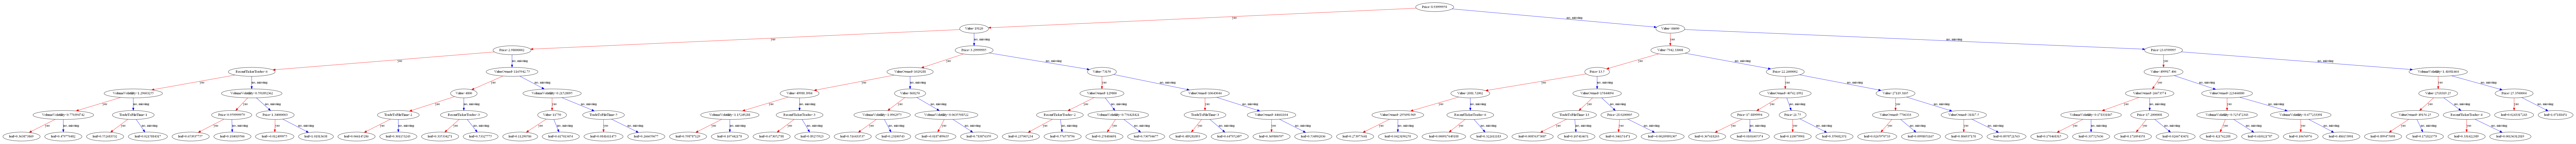

In [17]:
# Graphviz isn't on the environment's path by default for some reason, so we must add it
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin/'

xgb.plot_tree(xgb_model_custom_best)  # plot the first tree in the model
fig = plt.gcf()
fig.set_size_inches(150, 100)
plt.show()
fig.savefig('../outputs/regression_tree.png')

In [18]:
#cv_XY['XGB_Prediction'] = cv_Y_preds_custom
#my_misc.save_obj(cv_XY, 'data/cv_XY')

xgb_model_best.save_model('../models/xgb_model.json')